In [35]:
#****************************************************************************
# (C) Cloudera, Inc. 2020-2025
#  All rights reserved.
#
#  Applicable Open Source License: GNU Affero General Public License v3.0
#
#  NOTE: Cloudera open source products are modular software products
#  made up of hundreds of individual components, each of which was
#  individually copyrighted.  Each Cloudera open source product is a
#  collective work under U.S. Copyright Law. Your license to use the
#  collective work is as provided in your written agreement with
#  Cloudera.  Used apart from the collective work, this file is
#  licensed for your use pursuant to the open source license
#  identified above.
#
#  This code is provided to you pursuant a written agreement with
#  (i) Cloudera, Inc. or (ii) a third-party authorized to distribute
#  this code. If you do not have a written agreement with Cloudera nor
#  with an authorized and properly licensed third party, you do not
#  have any rights to access nor to use this code.
#
#  Absent a written agreement with Cloudera, Inc. (“Cloudera”) to the
#  contrary, A) CLOUDERA PROVIDES THIS CODE TO YOU WITHOUT WARRANTIES OF ANY
#  KIND; (B) CLOUDERA DISCLAIMS ANY AND ALL EXPRESS AND IMPLIED
#  WARRANTIES WITH RESPECT TO THIS CODE, INCLUDING BUT NOT LIMITED TO
#  IMPLIED WARRANTIES OF TITLE, NON-INFRINGEMENT, MERCHANTABILITY AND
#  FITNESS FOR A PARTICULAR PURPOSE; (C) CLOUDERA IS NOT LIABLE TO YOU,
#  AND WILL NOT DEFEND, INDEMNIFY, NOR HOLD YOU HARMLESS FOR ANY CLAIMS
#  ARISING FROM OR RELATED TO THE CODE; AND (D)WITH RESPECT TO YOUR EXERCISE
#  OF ANY RIGHTS GRANTED TO YOU FOR THE CODE, CLOUDERA IS NOT LIABLE FOR ANY
#  DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, PUNITIVE OR
#  CONSEQUENTIAL DAMAGES INCLUDING, BUT NOT LIMITED TO, DAMAGES
#  RELATED TO LOST REVENUE, LOST PROFITS, LOSS OF INCOME, LOSS OF
#  BUSINESS ADVANTAGE OR UNAVAILABILITY, OR LOSS OR CORRUPTION OF
#  DATA.
#
# #  Author(s): Oliver Zarate / Paul de Fusco
#***************************************************************************/

In [48]:
import cml.data_v1 as cmldata
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Connect to Spark
CONNECTION_NAME = "odl-aw-dl"  # Replace with your actual connection name
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

USERNAME = "jingalls"
DBNAME = USERNAME+"_airlines"

# Define database and load raw data
df = spark.table('{}.flights_silver'.format(DBNAME))
#df = spark.table(f"{DBNAME}.{TABLE_NAME}")

Spark Application Id:spark-application-1743376314621


In [49]:
df.show()

+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+----+
|month|dayofmonth|dayofweek|deptime|crsdeptime|arrtime|crsarrtime|uniquecarrier|flightnum|tailnum|actualelapsedtime|crselapsedtime|airtime|arrdelay|depdelay|origin|dest|distance|taxiin|taxiout|cancelled|cancellationcode|diverted|carrierdelay|weatherdelay|nasdelay|securitydelay|lateaircraftdelay|year|
+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+----+
|   12|         1|        6|   1212|      1220|   1315|      1333|           XE|       99| N13

In [50]:
# Define column types
numerical_cols = ["month", "dayofmonth", "dayofweek", \
                  "crsdeptime", \
                  "distance", "taxiout", "lateaircraftdelay"]
categorical_cols = ["diverted"]

# Cast numerical columns to double
for col_name in numerical_cols:
    df = df.withColumn(col_name, col(col_name).cast("double"))

# 1. Basic Descriptive Stats
print(f"Dataset Size: {df.count()} rows and {len(df.columns)} columns")
df.printSchema()
df.show(5)

Dataset Size: 6592 rows and 29 columns
root
 |-- month: double (nullable = true)
 |-- dayofmonth: double (nullable = true)
 |-- dayofweek: double (nullable = true)
 |-- deptime: integer (nullable = true)
 |-- crsdeptime: double (nullable = true)
 |-- arrtime: integer (nullable = true)
 |-- crsarrtime: integer (nullable = true)
 |-- uniquecarrier: string (nullable = true)
 |-- flightnum: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- actualelapsedtime: integer (nullable = true)
 |-- crselapsedtime: integer (nullable = true)
 |-- airtime: integer (nullable = true)
 |-- arrdelay: integer (nullable = true)
 |-- depdelay: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- distance: double (nullable = true)
 |-- taxiin: integer (nullable = true)
 |-- taxiout: double (nullable = true)
 |-- cancelled: integer (nullable = true)
 |-- cancellationcode: string (nullable = true)
 |-- diverted: string (nullable = true)
 |--

In [51]:
# Summary statistics for numerical columns
summary_df = df.select(numerical_cols).describe()
summary_df.show()

+-------+-----+----------+---------+------------------+------------------+------------------+-----------------+
|summary|month|dayofmonth|dayofweek|        crsdeptime|          distance|           taxiout|lateaircraftdelay|
+-------+-----+----------+---------+------------------+------------------+------------------+-----------------+
|  count| 6592|      6592|     6592|              6592|              6592|              6592|             6592|
|   mean| 12.0|       1.0|      6.0|1260.6231796116506|470.84678398058253|17.337682038834952|3.599514563106796|
| stddev|  0.0|       0.0|      0.0|438.56103165066867| 294.9281882234092|15.389162640512382|19.31738568073461|
|    min| 12.0|       1.0|      6.0|             500.0|              36.0|               0.0|              0.0|
|    max| 12.0|       1.0|      6.0|            2359.0|            1659.0|             224.0|            310.0|
+-------+-----+----------+---------+------------------+------------------+------------------+-----------

#### Correlation Matrix

Computing Correlation Matrix...


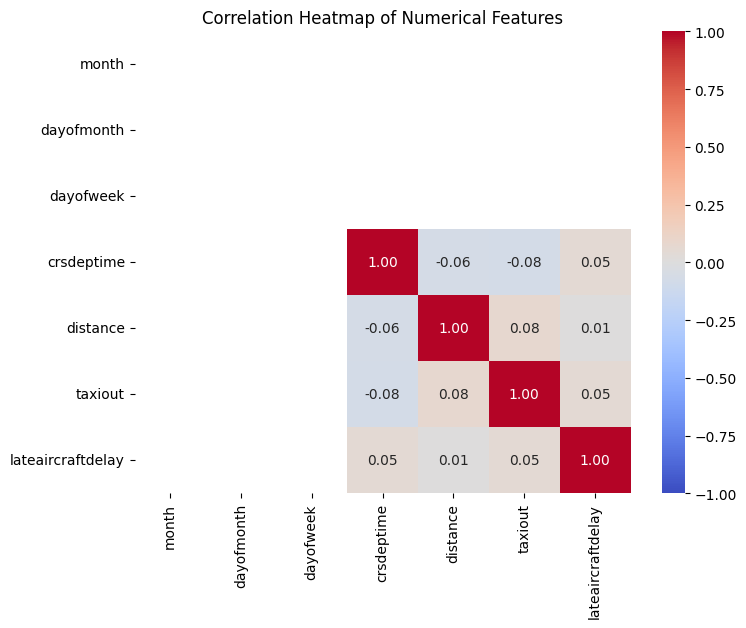

In [52]:
print("Computing Correlation Matrix...")
corr_matrix = np.zeros((len(numerical_cols), len(numerical_cols)))
for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        if i <= j:
            corr_matrix[i, j] = df.stat.corr(col1, col2)
            corr_matrix[j, i] = corr_matrix[i, j]

corr_df = pd.DataFrame(corr_matrix, index=numerical_cols, columns=numerical_cols)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [53]:
# Correlation with target
#df = df.withColumn("y_binary", when(col("y") == "yes", 1.0).otherwise(0.0))
for col_name in numerical_cols:
    corr_value = df.stat.corr(col_name, "lateaircraftdelay")
    print(f"Correlation between {col_name} and lateaircraftdelay: {corr_value:.3f}")

Correlation between month and lateaircraftdelay: nan
Correlation between dayofmonth and lateaircraftdelay: nan
Correlation between dayofweek and lateaircraftdelay: nan
Correlation between crsdeptime and lateaircraftdelay: 0.049
Correlation between distance and lateaircraftdelay: 0.007
Correlation between taxiout and lateaircraftdelay: 0.054
Correlation between lateaircraftdelay and lateaircraftdelay: 1.000


### Late Aircraft Arrival Distribution

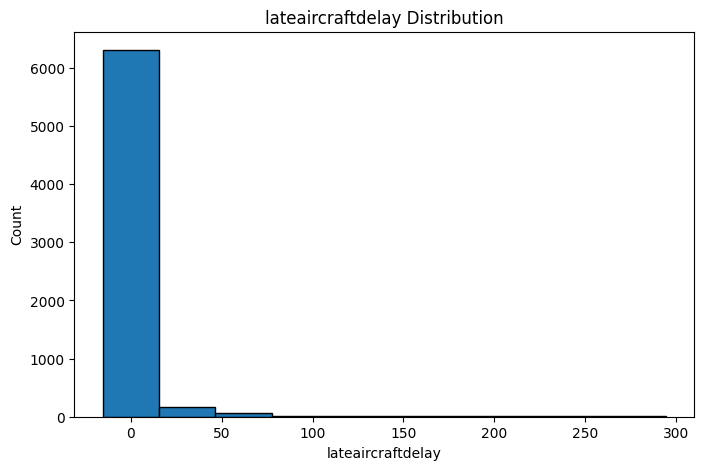

In [54]:
age_hist = df.select("lateaircraftdelay").rdd.flatMap(lambda x: x).histogram(10)
plt.figure(figsize=(8, 5))
plt.bar(age_hist[0][:-1], age_hist[1], width=(age_hist[0][1] - age_hist[0][0]), edgecolor='black')
plt.title("lateaircraftdelay Distribution")
plt.xlabel("lateaircraftdelay")
plt.ylabel("Count")
plt.show()

### Diverted Bar Plot

/tmp/ipykernel_268/186392045.py:3: FutureWarning:                               

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="diverted", y="count", data=job_counts, palette="viridis")


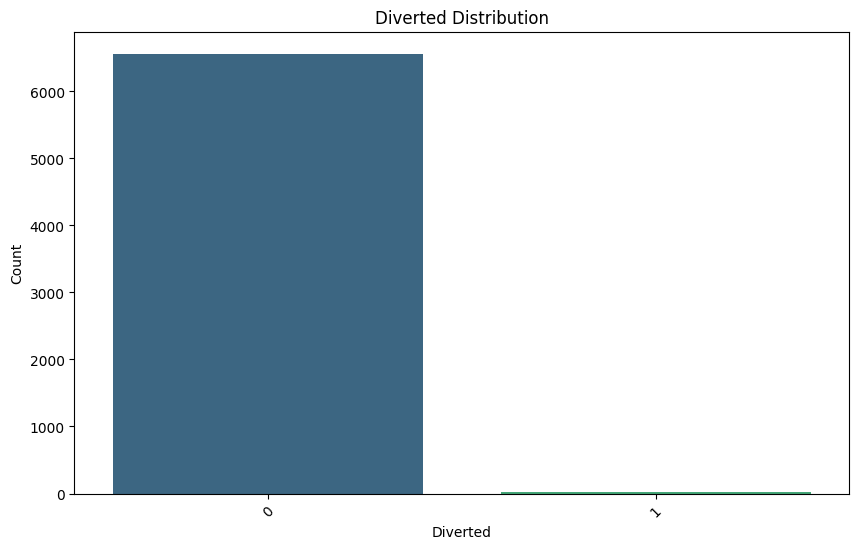

In [55]:
job_counts = df.groupBy("diverted").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="diverted", y="count", data=job_counts, palette="viridis")
plt.title("Diverted Distribution")
plt.xlabel("Diverted")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [56]:
df = df.withColumn("diverted", df.diverted.cast('double'))

### Check Nulls

In [57]:
from pyspark.sql.functions import col, sum

def count_nulls(df):
    """
    Counts null values in each column of a PySpark DataFrame.

    Args:
        df: The input PySpark DataFrame.

    Returns:
        A PySpark DataFrame containing the null counts for each column.
    """
    null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    return null_counts

# Example usage:
# Assuming you have a SparkSession named 'spark' and a DataFrame named 'df'
null_counts_df = count_nulls(df.select(numerical_cols))
null_counts_df.show()

+-----+----------+---------+----------+--------+-------+-----------------+
|month|dayofmonth|dayofweek|crsdeptime|distance|taxiout|lateaircraftdelay|
+-----+----------+---------+----------+--------+-------+-----------------+
|    0|         0|        0|         0|       0|      0|                0|
+-----+----------+---------+----------+--------+-------+-----------------+



In [58]:
df.dtypes

[('month', 'double'),
 ('dayofmonth', 'double'),
 ('dayofweek', 'double'),
 ('deptime', 'int'),
 ('crsdeptime', 'double'),
 ('arrtime', 'int'),
 ('crsarrtime', 'int'),
 ('uniquecarrier', 'string'),
 ('flightnum', 'int'),
 ('tailnum', 'string'),
 ('actualelapsedtime', 'int'),
 ('crselapsedtime', 'int'),
 ('airtime', 'int'),
 ('arrdelay', 'int'),
 ('depdelay', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('distance', 'double'),
 ('taxiin', 'int'),
 ('taxiout', 'double'),
 ('cancelled', 'int'),
 ('cancellationcode', 'string'),
 ('diverted', 'double'),
 ('carrierdelay', 'int'),
 ('weatherdelay', 'int'),
 ('nasdelay', 'int'),
 ('securitydelay', 'int'),
 ('lateaircraftdelay', 'double'),
 ('year', 'int')]

In [64]:
train_df = df.select(["month", "dayofmonth", "dayofweek", \
                  "crsdeptime", \
                  "distance", "taxiout", "lateaircraftdelay", "diverted"])

In [67]:
train_df.show()

+-----+----------+---------+----------+--------+-------+-----------------+--------+
|month|dayofmonth|dayofweek|crsdeptime|distance|taxiout|lateaircraftdelay|diverted|
+-----+----------+---------+----------+--------+-------+-----------------+--------+
| 12.0|       1.0|      6.0|    1220.0|   283.0|   10.0|              0.0|     0.0|
| 12.0|       1.0|      6.0|    1210.0|   222.0|   13.0|              0.0|     0.0|
| 12.0|       1.0|      6.0|    1315.0|   670.0|   13.0|              0.0|     0.0|
| 12.0|       1.0|      6.0|    1025.0|   789.0|   11.0|             71.0|     0.0|
| 12.0|       1.0|      6.0|    1350.0|   789.0|    7.0|              0.0|     0.0|
| 12.0|       1.0|      6.0|    1120.0|   670.0|   13.0|              0.0|     0.0|
| 12.0|       1.0|      6.0|    1040.0|   222.0|   15.0|              0.0|     0.0|
| 12.0|       1.0|      6.0|    1400.0|   660.0|   24.0|              0.0|     0.0|
| 12.0|       1.0|      6.0|     830.0|   660.0|   13.0|              0.0|  

In [68]:
df = spark.table('{}.flights_silver'.format(DBNAME))

In [71]:
numerical_cols

['month',
 'dayofmonth',
 'dayofweek',
 'crsdeptime',
 'distance',
 'taxiout',
 'lateaircraftdelay']

In [69]:
print("\nTraining Decision Tree for Feature Importance...")
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx") for col in categorical_cols]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)

all_features = numerical_cols + [f"{col}_idx" for col in categorical_cols]
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
dt_df = assembler.transform(df_indexed)

dt = DecisionTreeClassifier(featuresCol="features", labelCol="diverted", maxDepth=5)
dt_model = dt.fit(dt_df)

importances = dt_model.featureImportances
feature_importance_dict = {all_features[i]: importances[i] for i in range(len(all_features)) if importances[i] > 0}
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
total_importance = sum(importance for _, importance in sorted_importances)
print("\nFeature Importance Table:")
print(f"{'Feature':<20} {'Importance':<15} {'Percent Importance':<15}")
print("-" * 50)
for feature, importance in sorted_importances:
    percent_importance = (importance / total_importance) * 100 if total_importance > 0 else 0
    print(f"{feature:<20} {importance:<15.4f} {percent_importance:<15.2f}%")


Training Decision Tree for Feature Importance...


IllegalArgumentException: requirement failed: Column diverted must be of type numeric but was actually of type string.

### Select top features and save

In [ ]:
top_features = [f[0] for f in sorted_importances[:10]]
df_selected = df_indexed.select(top_features + ["fraud_trx"])
df_selected.show(5)
df_selected.writeTo(f"{DBNAME}.SELECTED_FEATURES_{USERNAME}")\
    .using("iceberg").tableProperty("write.format.default", "parquet")\
    .createOrReplace()
print("Selected features saved as {}.SELECTED_FEATURES_{}".format(DBNAME, USERNAME))

# Verify the save
print("Tables in {}:".format(USERNAME))
spark.sql(f"SHOW TABLES IN {DBNAME}").show(truncate=False)

+-------+----------------+--------------------+-------------------+------------------------+-----------------------+---------------------------+----+---------+
|job_idx|mortgage_balance|bank_account_balance|credit_card_balance|sec_bank_account_balance|savings_account_balance|sec_savings_account_balance| age|fraud_trx|
+-------+----------------+--------------------+-------------------+------------------------+-----------------------+---------------------------+----+---------+
|    5.0| 28308.009765625|     16840.009765625|            21305.0|          51828.01171875|               355457.0|                   308440.0|75.0|        0|
|    4.0|        596398.0|     15265.009765625|             4287.0|         21743.009765625|               402794.0|                   321811.0|87.0|        1|
|    8.0|        858722.0|  137.00999450683594|            15322.0|         22198.009765625|               298947.0|                   363054.0|90.0|        0|
|    3.0|        919655.0|      6776.009